In [1]:
#XGBoost
import pandas as pd
import numpy as np

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
%matplotlib inline

In [5]:
from os.path import dirname, join
from pathlib import Path
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR,"data","room_info.csv")  # requires `import os`

# input data
data = pd.read_csv(r'C:\Users\milad\Documents\GitHub\arch7211-spring2021\data\room_info.csv')

In [6]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other"]
merge = {
    "Sauna": "Bath",
    "Den":'LivingRoom',
    "Library": "Office",
    "DressingRoom":'Closet'
}

data["type_cleaned"] = data["type"].apply(lambda x: merge.get(x,x))
data["exclude"] = ~data["type"].isin(exclusion)

In [7]:
data_exclude = data[~data["type"].isin(exclusion)]

In [8]:
data_exclude.groupby("type_cleaned",as_index=False).count().sort_values("type_cleaned")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
0,Alcove,164,164,164,164,164,164,164,164,164,...,164,164,164,164,164,164,164,164,164,164
1,Attic,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
2,Basement,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
3,Bath,7288,7288,7288,7288,7288,7288,7288,7288,7288,...,7288,7288,7288,7288,7288,7288,7288,7288,7288,7288
4,Bedroom,7993,7993,7993,7993,7993,7993,7993,7993,7993,...,7993,7993,7993,7993,7993,7993,7993,7993,7993,7993
5,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
7,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
8,DraughtLobby,1667,1667,1667,1667,1667,1667,1667,1667,1667,...,1667,1667,1667,1667,1667,1667,1667,1667,1667,1667
9,Elevated,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [9]:
#Clean input data from the target data
# define features and predictions
X = data_exclude.drop(['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'], axis =1)
y = data_exclude['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)


In [10]:
print(XGBClassifier())

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [11]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    n_estimators = 200,
                    subsample= 0.9,
                    colsample_bytree = 0.6)
print(xgb)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [12]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=10,
        verbose=True)

lidation_1-mlogloss:0.21177	validation_1-merror:0.06114
[36]	validation_0-mlogloss:0.21014	validation_0-merror:0.06067	validation_1-mlogloss:0.20834	validation_1-merror:0.06008
[37]	validation_0-mlogloss:0.20747	validation_0-merror:0.06014	validation_1-mlogloss:0.20591	validation_1-merror:0.05932
[38]	validation_0-mlogloss:0.20489	validation_0-merror:0.05955	validation_1-mlogloss:0.20333	validation_1-merror:0.05861
[39]	validation_0-mlogloss:0.20167	validation_0-merror:0.05903	validation_1-mlogloss:0.20001	validation_1-merror:0.05784
[40]	validation_0-mlogloss:0.19894	validation_0-merror:0.05832	validation_1-mlogloss:0.19757	validation_1-merror:0.05720
[41]	validation_0-mlogloss:0.19559	validation_0-merror:0.05696	validation_1-mlogloss:0.19429	validation_1-merror:0.05619
[42]	validation_0-mlogloss:0.19246	validation_0-merror:0.05567	validation_1-mlogloss:0.19128	validation_1-merror:0.05490
[43]	validation_0-mlogloss:0.19006	validation_0-merror:0.05478	validation_1-mlogloss:0.18879	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
evals_result = xgb.evals_result()

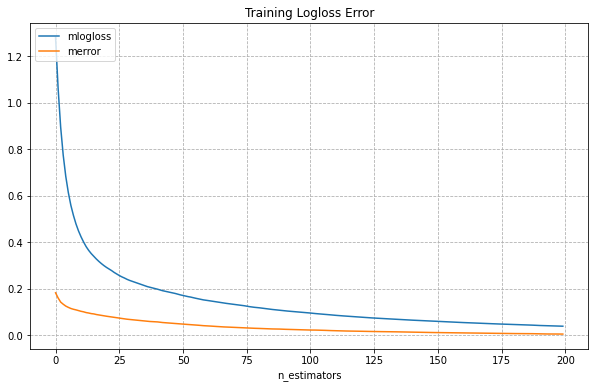

In [14]:


rcParams['figure.figsize'] = 10,6
plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.show()

In [15]:
train_score = xgb.score(X_train,y_train,)
print("Training score: ",train_score)

Training score:  0.9936088121815451


In [16]:
# cv_score = cross_val_score(xgb,X_train,y_train, cv=10)
# print("CV mean score: ",cv_score.mean())

In [17]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

200


In [18]:
print(classification_report(y_test,y_pred))

                precision    recall  f1-score   support

        Alcove       0.67      0.60      0.64        48
         Attic       0.87      0.36      0.51        36
      Basement       0.00      0.00      0.00        19
          Bath       0.96      0.96      0.96      2137
       Bedroom       0.83      0.95      0.88      2365
       CarPort       0.77      0.54      0.64        94
        Closet       0.85      0.88      0.86       877
        Dining       0.89      0.89      0.89       284
  DraughtLobby       0.94      0.92      0.93       554
      Elevated       0.55      0.39      0.46        28
         Entry       0.90      0.93      0.92      1270
        Garage       0.76      0.77      0.77       134
          Hall       0.57      0.17      0.26        47
       Kitchen       0.98      0.96      0.97      1350
    LivingRoom       0.85      0.92      0.88      1259
        Office       0.50      0.03      0.06        64
       Outdoor       0.96      0.97      0.97  

<AxesSubplot:>

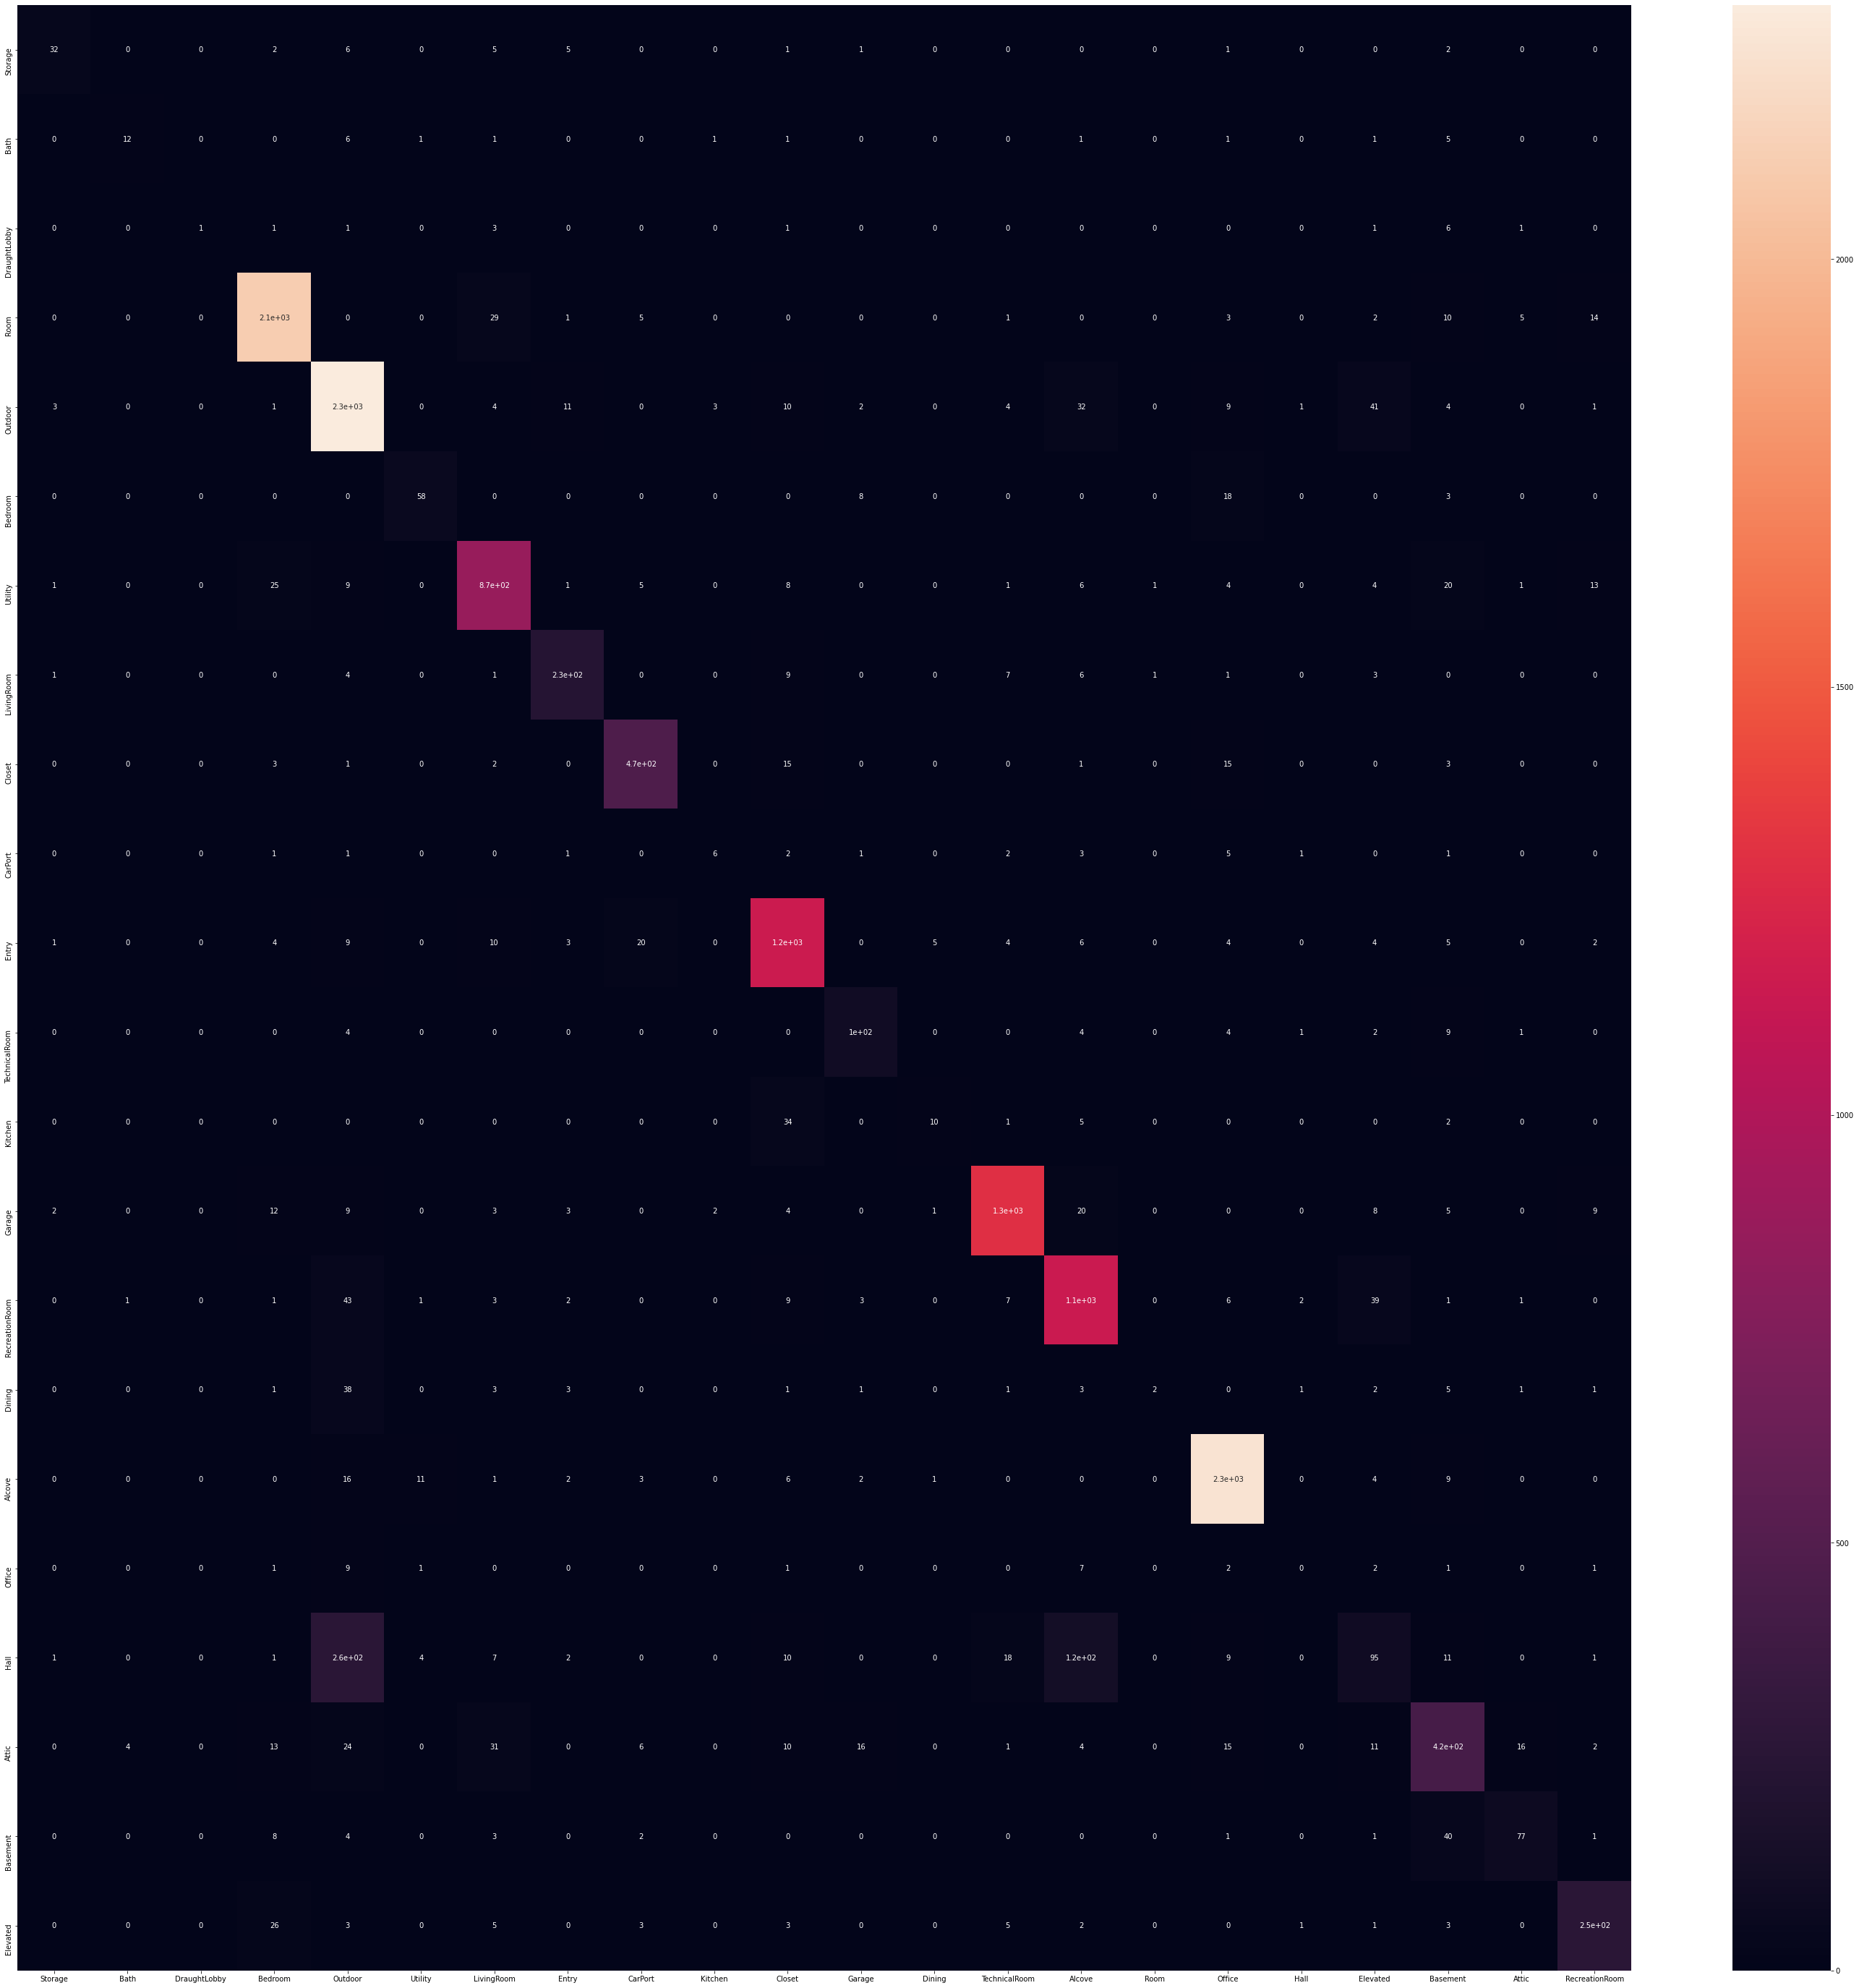

In [62]:
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
sns.heatmap(df_cm, annot=True)

In [19]:
f_import = list(zip(X_train_train,xgb.feature_importances_))
for name,score in sorted(f_import, key = lambda x: x[1], reverse = True):
    print(name,score)

contains_Refrigerator 0.28804204
contains_Shower 0.21645756
contains_Stove 0.053894583
contains_Sink 0.03555992
open_to_Entry 0.021725005
contains_Toilet 0.020084843
contains_BaseCabinet 0.01991265
door_to_Closet 0.018906267
contains_WashingMachine 0.018197851
contains_CoatCloset 0.015763365
num_adjacent_rooms 0.014763273
contains_Heater 0.014441691
num_adjacent_walls 0.013057286
open_to_Kitchen 0.012839905
num_doors 0.012069355
contains_SaunaStove 0.011441811
contains_Fireplace 0.009789462
open_to_LivingRoom 0.009657991
door_to_CarPort 0.009073498
door_to_Sauna 0.008579725
door_to_Bedroom 0.007637821
door_to_Bath 0.0071856854
num_adjacent_railings 0.0069878674
contains_Closet 0.006823013
open_to_Dining 0.0054995394
num_fixtures 0.005349331
num_windows 0.005135488
contains_SaunaBench 0.004800065
door_to_Outdoor 0.004576374
open_to_Outdoor 0.0041312277
door_to_Entry 0.004101946
num_connected_rooms 0.0040417723
door_to_Garage 0.003961353
contains_GEA 0.003847634
open_to_CarPort 0.0036028

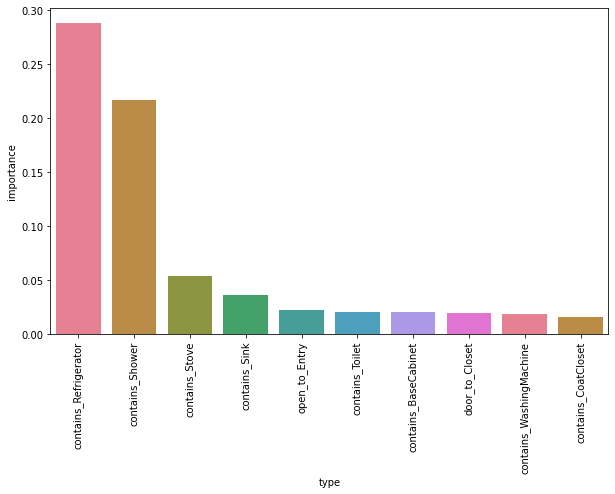

In [20]:
feat_imp = pd.DataFrame(data= {'type':[x[0] for x in f_import] , 'importance':[x[1] for x in f_import]}).sort_values('importance', ascending= False)
feat_imp
fig1 = sns.barplot(x='type',y='importance',data= feat_imp.head(10), palette=sns.color_palette("husl", 8))
plt.xticks(rotation=90)
plt.show()
# sns.lineplot((x[0] for x in f_import) , (x[1] for x in f_import) )

In [22]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    learning_rate = 0.01,
                    max_depth=6,
                    n_estimators = 200)
print(xgb)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [23]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=10,
        verbose=True)

lidation_1-mlogloss:1.84782	validation_1-merror:0.12694
[36]	validation_0-mlogloss:1.83518	validation_0-merror:0.12659	validation_1-mlogloss:1.82990	validation_1-merror:0.12676
[37]	validation_0-mlogloss:1.81744	validation_0-merror:0.12653	validation_1-mlogloss:1.81207	validation_1-merror:0.12629
[38]	validation_0-mlogloss:1.80056	validation_0-merror:0.12635	validation_1-mlogloss:1.79513	validation_1-merror:0.12540
[39]	validation_0-mlogloss:1.78328	validation_0-merror:0.12612	validation_1-mlogloss:1.77780	validation_1-merror:0.12482
[40]	validation_0-mlogloss:1.76674	validation_0-merror:0.12559	validation_1-mlogloss:1.76126	validation_1-merror:0.12464
[41]	validation_0-mlogloss:1.75021	validation_0-merror:0.12512	validation_1-mlogloss:1.74470	validation_1-merror:0.12470
[42]	validation_0-mlogloss:1.73419	validation_0-merror:0.12500	validation_1-mlogloss:1.72860	validation_1-merror:0.12458
[43]	validation_0-mlogloss:1.71871	validation_0-merror:0.12524	validation_1-mlogloss:1.71313	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
evals_result = xgb.evals_result()

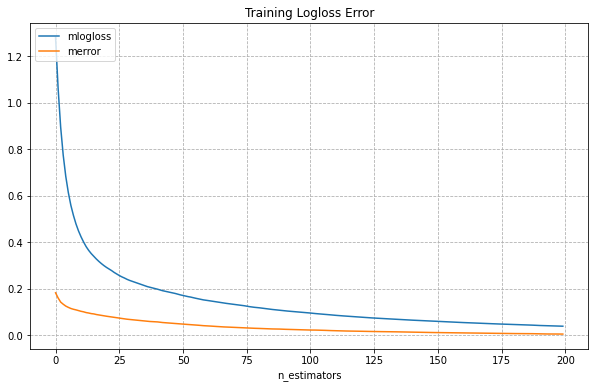

In [24]:
rcParams['figure.figsize'] = 10,6
plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.show()

In [25]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

200


In [26]:
print(classification_report(y_test,y_pred))

                precision    recall  f1-score   support

        Alcove       0.72      0.60      0.66        48
         Attic       0.92      0.31      0.46        36
      Basement       0.00      0.00      0.00        19
          Bath       0.97      0.95      0.96      2137
       Bedroom       0.78      0.96      0.86      2365
       CarPort       0.88      0.32      0.47        94
        Closet       0.80      0.88      0.84       877
        Dining       0.85      0.87      0.86       284
  DraughtLobby       0.92      0.93      0.92       554
      Elevated       0.67      0.14      0.24        28
         Entry       0.89      0.94      0.92      1270
        Garage       0.76      0.66      0.71       134
          Hall       1.00      0.15      0.26        47
       Kitchen       0.96      0.95      0.96      1350
    LivingRoom       0.82      0.93      0.87      1259
        Office       0.00      0.00      0.00        64
       Outdoor       0.94      0.97      0.95  

In [13]:
#Reproductability
seed = 342
np.random.seed(seed)

In [27]:
#Grid Search

#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [1,3,6],
    'n_estimators' : [200,400],
    'learning_rate' : [0.01, 1] 
                }
params_fixed = {
    'objective' : 'multi:softprob',
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring='f1_macro')

In [28]:
fit_params = {
        'eval_set':[(X_train, y_train), (X_test, y_test)],
        'eval_metric':['mlogloss','auc'],
        'early_stopping_rounds':10
                }
bst_grid.fit(X_train,y_train,**fit_params)


8617
[97]	validation_0-mlogloss:1.13106	validation_1-mlogloss:1.17896
[98]	validation_0-mlogloss:1.12374	validation_1-mlogloss:1.17189
[99]	validation_0-mlogloss:1.11645	validation_1-mlogloss:1.16487
[100]	validation_0-mlogloss:1.10927	validation_1-mlogloss:1.15796
[101]	validation_0-mlogloss:1.10219	validation_1-mlogloss:1.15114
[102]	validation_0-mlogloss:1.09514	validation_1-mlogloss:1.14438
[103]	validation_0-mlogloss:1.08822	validation_1-mlogloss:1.13772
[104]	validation_0-mlogloss:1.08137	validation_1-mlogloss:1.13116
[105]	validation_0-mlogloss:1.07457	validation_1-mlogloss:1.12461
[106]	validation_0-mlogloss:1.06786	validation_1-mlogloss:1.11816
[107]	validation_0-mlogloss:1.06125	validation_1-mlogloss:1.11182
[108]	validation_0-mlogloss:1.05474	validation_1-mlogloss:1.10555
[109]	validation_0-mlogloss:1.04828	validation_1-mlogloss:1.09934
[110]	validation_0-mlogloss:1.04192	validation_1-mlogloss:1.09324
[111]	validation_0-mlogloss:1.03557	validation_1-mlogloss:1.08713
[112]	va

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...onstraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     re

In [41]:
print('Best params:',bst_grid.best_params_)

Best params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}


In [42]:
bst_pred = bst_grid.predict(X_test)

In [46]:
print(classification_report(y_test,bst_pred))
print(confusion_matrix(y_test,bst_pred))

                precision    recall  f1-score   support

        Alcove       0.70      0.66      0.68        56
         Attic       0.60      0.48      0.53        25
      Basement       0.00      0.00      0.00        16
          Bath       0.97      0.96      0.96      2200
       Bedroom       0.81      0.96      0.88      2377
       CarPort       0.70      0.45      0.55        85
        Closet       0.87      0.92      0.90       828
           Den       0.58      0.47      0.52        81
        Dining       0.88      0.88      0.88       300
  DraughtLobby       0.88      0.93      0.90       501
  DressingRoom       0.62      0.49      0.54       107
      Elevated       0.71      0.18      0.29        28
         Entry       0.91      0.92      0.92      1275
        Garage       0.73      0.70      0.72       134
          Hall       0.88      0.15      0.25        47
       Kitchen       0.97      0.95      0.96      1387
       Library       0.00      0.00      0.00  

In [45]:
# bst_grid.score(X)

ValueError: Expected array-like (array or non-string sequence), got None